# Test Stability of U 
#### (Using subsets of different sizes of the Tonsil data)

## Import Libraries

First, we import the neccessary libraries.

In [1]:
# Import libraries
import anndata as ad
from pathlib import Path
import errno
import os
import numpy as np
import pandas as pd
import seaborn as sns

## Helper Functions

Next, we import some helper functions including the cisi segementation training function.

In [2]:
# Helper fncs
import analysis_utils


## CISI
# Import system libraries to configure code directory as module
from os.path import dirname, abspath, join
import sys

# Find code directory relative to our directory
THIS_DIR = dirname('__file__')
CODE_DIR = abspath(join(THIS_DIR, '..', 'code'))
# Add code directory to systems paths
sys.path.append(CODE_DIR)

# Import dictionary training fnc. (smaf)
from compute_dictionary import smaf


# Define fnc to compare correlation matrices
def compare_cor(A, B):
    return np.sum(abs(A - B))

## Inputs

In the first part we specify the paths to the input files (.h5ad files created from R) and where the outputs should be stored.

In [25]:
# Specify input paths
training_data_path = Path('/mnt/bb_dqbm_volume/data/Tonsil_th152')
spe_path = Path(os.path.join(training_data_path, 'preprocessed_data/spe.h5ad'))


# Specify output path
out_path = Path(os.path.join(training_data_path, 'analysis/tests/test_U_stability'))
out_path_d = Path(os.path.join(training_data_path, 'analysis/tests/test_U_stability_par/d'))

# Create output directory if it doesn't exist
out_path.mkdir(parents=True, exist_ok=True)
out_path_d.mkdir(parents=True, exist_ok=True)

In [5]:
# Check that input files/dictionary exist
if not analysis_utils.is_valid_file(spe_path, ['.h5ad']):
    # If file is not found, throw error
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT),
                            spe_path)

Next, we read in the input files for training U and testing its stability concerning subsets of different sizes. For this we have the Tonsil th152 dataset consisting of 5 ROIs and we read the data in once it has been processed by steinbock into segmented single cells.

In [6]:
# Read in SpatialExperiment converted to anndata by cellconverter in R
spe = ad.read_h5ad(spe_path)
spe = spe[:, ~spe.var.index.str.contains('Histone|Ir[0-9]', regex=True, case=False)]
print(spe)

View of AnnData object with n_obs × n_vars = 162624 × 40
    obs: 'sample_id', 'ObjectNumber', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'ROI'
    var: 'channel', 'name', 'keep', 'ilastik', 'deepcell', 'Tube.Number', 'Metal', 'use_channel'
    uns: 'X_name'
    layers: 'exprs', 'log_exprs'


Next, we specify the parameters we want to use to compute the dictionary and how many times to assess it.


In [7]:
# Set non-default parameters of smaf
d = 80
lda1 = 3
lda2 = 0.2

# Set parameters for stability analysis of U
n_sizes = 10
n_rep = 10

## Check different training sizes

In the following paragraphs, we compute the "ground truth" correlation between proteins in U by computing the correlation matrix of U of the full dataset n_rep times and taking its average. Then we compare this to the results of input data sets of different sizes (by taking the sum of the absolut differences between ground truth and each result).

In [17]:
# Calculate "ground truth" by computing the average correlation matrix of the full dataset
cor_list = [-10.0] * n_rep 
for i in range(n_rep):
        U, W = smaf(spe, d, lda1, lda2, normalization='paper_norm', layer=None,
                    outpath=os.path.join(out_path, str(spe.shape[0]), str(i)))
        cor_w_diag = np.corrcoef(U)
        # Remove diagonal
        cor_list[i] = cor_w_diag[~np.eye(len(cor_w_diag), dtype=bool)].reshape(len(cor_w_diag), -1)

# Calculate "ground truth" as average of the five runs of the full data set
cor_ground_truth = sum(cor_list) / n_rep


# Initialize list of lists to hold results of distances between correlation matrices
# cor_list_subset = [-10] * 6
# cor_list_subset[5] = [compare_cor(c, cor_ground_truth) for c in pages]
cor_list_subset = np.full((n_rep, n_sizes), 10.0)
cor_list_subset[:, (n_sizes-1)] = np.array([compare_cor(c, cor_ground_truth) for c in cor_list])

In [18]:
## Calculate correlation matrix of the subsets of the dataset
# For different subset sizes of spe, caculate n_rep times U and compare how close its
# columnwise correlations are to the mean correlation matrix of the full dataset (excluding)
# the diagonal
j = 0
for s in np.linspace(20000, spe.shape[0], n_sizes-1, dtype=int, endpoint=False):
    for i in range(n_rep):
        X_subset = spe[np.random.randint(spe.shape[0], size=(s)), ]
        
        U, W = smaf(X_subset, d, lda1, lda2, outpath=os.path.join(out_path, str(s), str(i)), 
                    normalization='paper_norm', layer=None)
        cor_w_diag = np.corrcoef(U)
        cor_wt_diag = cor_w_diag[~np.eye(len(cor_w_diag), dtype=bool)].reshape(len(cor_w_diag), -1)
        
        cor_list_subset[i, j] = compare_cor(cor_wt_diag, cor_ground_truth)
    
    j+=1
        

/home/ubuntu/anaconda3/envs/cisi_imc_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/ubuntu/anaconda3/envs/cisi_imc_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ubuntu/anaconda3/envs/cisi_imc_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ubuntu/anaconda3/envs/cisi_imc_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/ubuntu/anaconda3/envs/cisi_imc_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ubuntu/anaconda3/envs/cisi_imc_env/lib/pyt

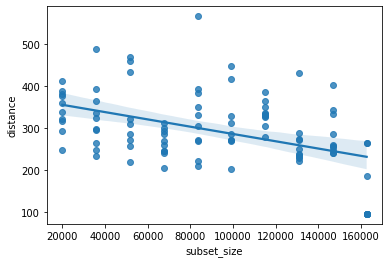

In [24]:
# Convert into pandas dataframe for easier handling
cor_pd = pd.DataFrame(cor_list_subset, 
                      columns=np.append(np.linspace(20000, spe.shape[0], 
                                          n_sizes-1, dtype=int, endpoint=False), spe.shape[0]))
# Melt dataframe into long format for plotting
cor_pd_long = pd.melt(cor_pd, var_name='subset_size', value_name='distance')

# Use seaborns regression fnc of order 2 to plot results
ax = sns.regplot(x="subset_size", y="distance", data=cor_pd_long, order=1)

## Check different parameters
### k-sparsity (lda1)

In [29]:
# Specify list of k to try (1 to 10)
k = np.arange(1, 10+1)
for i in k:
    for j in range(n_rep):
        U, W = smaf(spe, d, i, lda2, normalization='paper_norm', layer=None,
                    outpath=os.path.join(out_path_d, str(i), str(j)))
        

## Save results

In [22]:
cor_pd.to_csv(os.path.join(out_path, "results.csv"))